#Proyecto 2
## Ecuación Difusión-Reacción,  caso dinámico
Métodos numéricos  para ecuaciones diferenciales - 2014_I

**Nataly Neira  , cod: 614212782**

**Juan Sebastián Vargas Arévalo cod: 614221007**

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sparse
from matplotlib.animation import FuncAnimation

# Funciones para  graficar

In [4]:

def graf_solucion_continua(yt,a,b):
  resol = 512
  tn = np.linspace(a,b,resol + 1)
  yn = np.zeros(resol+1)
  for n in range(resol+1):
    yn[n]=yt( tn[n] )
  plt.plot(tn,yn,'-b',label='Exacta')

def graf_solucion_discreta(th,yh,text=''):
  # yh, th con longitud N+1 deben incluir valor inicial y0 y tiempo inicial t0
  plt.plot(th,yh,':.r',label=('Aprox '+ text))
  plt.xlabel('r')
  plt.ylabel('u(r,t)')
  plt.grid(True)

#Soluciones manufacturadas

In [5]:
# Soluciones manufacturadas
def u_exacta(x,t):
  match problema:
    case 0:
      u = -np.exp(-t)*np.cos(np.pi*x)
    case 1:
      u = np.exp(x-t)
    case 2:
      u= (2*x+1)*(np.exp(t))
  return u

def du_exacta(x,t):
  match problema:
    case 0:
      du = np.exp(-t)*np.sin(np.pi*x)*np.pi
    case 1:
      du = np.exp(x-t)
    case 2:
      du = (2)*(np.exp(t))
  return du

def d2u_exacta(x,t):
  match problema:
    case 0:
      d2u = np.exp(-t)*np.cos(np.pi*x)*(np.pi**2)
    case 1:
      d2u = np.exp(x-t)
    case 2:
      d2u = 0
  return d2u

def dudt_exacta(x,t):
  match problema:
    case 0:
      dudt = np.exp(-t)*np.cos(np.pi*x)
    case 1:
      dudt = - np.exp(x-t)
    case 2:
      dudt = (2*x+1)*(np.exp(t))
  return dudt

# Cargas
$$\frac{\partial U}{\partial t}-a \nabla^2U +cU=f$$
 cuando  la  geometria  es esferica y se desprecia la variacion de $\theta, \phi $  tenemos la  ecuación  
 $$\frac{\partial U}{\partial t}-\frac{a}{r^2} \frac{\partial}{\partial r}\left(r^2\frac{\partial}{\partial r}\right) U +cU=f$$
  por lo tanto queda
 $$U_t-aU_{rr}-\frac{2a}{r}U_r +c U =f(r,t)$$

 Que representa la ecuacipon diferencial  de difución-reacción dependiente del  radio y del tiempo .

In [6]:
def fuente(x,t,cond_sis):
  if manufacturada:
    # en este caso, se aplica el operador diferencial a solución manufacturada
    f = dudt_exacta(x,t)-(coef_a*d2u_exacta(x,t))-(2*coef_a/x)*du_exacta(x,t) + (coef_c*u_exacta(x,t))
  else:
     match cond_sis:
      case 'anillo':
        f = 0.1                            #  fuente  con generación de calor  constante
      case 'lago':
        f = 3 *np.sin((4*np.pi/10)*t)       #  fuente  contaminante periodico
      case 'esfera':
        f =-0.2 *x                            #  fuente  con  consumo de reactivo constante

  return f

def d_izq(x_izq,t,cond_sis):
  if manufacturada:
    d = u_exacta(x_izq,t)
  else:
    match cond_sis:
      case 'anillo':
        d = 100                       # CF  una  temperatura inicial  cte  en el centro del sistema
      case 'lago':
        d = 100                         # CF  una  consentración  inicial  cte  en el centro del Lago

  return d

def d_der(x_der,t,cond_sis):
  if manufacturada:
    d = u_exacta(x_der,t)
  else:
    match cond_sis:
      case 'anillo':
        d = 35                        # CF  una  consentración  inicial  cte  en el borde del anillo
      case 'esfera':
        d = -40                          # CF  una  temperatura inicial  cte  en el centro del sistema

  return d


def dddt_izq(x_izq,t):
  if manufacturada:
    dddt = dudt_exacta(x_izq,t)
  else:
    dddt = 0              # para las  condiciones  iniciales el valor  es cero
  return dddt

def dddt_der(x_der,t):
  if manufacturada:
    dddt = dudt_exacta(x_der,t)
  else:
    dddt = 0
  return dddt



def g_izq(x_izq,t):
  if manufacturada:
    g =-coef_a*du_exacta(x_izq,t)
  else:
    g = 0                           # para las  condiciones  iniciales el valor  es cero
  return g

def g_der(x_der,t):
  if manufacturada:
    g = coef_a*du_exacta(x_der,t)
  else:
    g = 0
  return g

def u_inicial(x,x_der,cond_sis):  #u(x,0)
  if manufacturada:
    ux0 = u_exacta(x,0)
  else:
    match cond_sis:
      case 'anillo':
        ux0 = 100*np.exp(-(x/x_der)**2)  # CI se usa  una  distribución inicial de temperatura  cualquiera
      case 'lago':
        ux0=0                          # CI se usa   un vector de ceros
      case 'esfera':
        ux0=-40*np.exp(1-(x/x_der)**2)  # CI se usa  una  distribución inicial de reactivo  cualquiera
  return ux0

def tasa_cambio_sistema(x_izq,cond_izq,x_der,cond_der,M,t,U,cond_sis):
  K,F,_ = MDF_matrices(x_izq,cond_izq,x_der,cond_der,M,t,cond_sis)
  return - K.dot(U) + F

def jacobiano_sistema(x_izq,cond_izq,x_der,cond_der,M,t,U,cond_sis):
  K,F,_ = MDF_matrices(x_izq,cond_izq,x_der,cond_der,M,t,cond_sis)
  return -K



# Método de diferencias finitas en espacio
con nodos internos
$$-\frac{a}{h^2}U_{i-1}+\left(\frac{2a}{r_ih}+\frac{2a}{h^2}+c \right)U_i+\left(-\frac{2a}{hr_i}-\frac{2a}{h^2}\right)U_{i+1}=f_i $$

condicion Dirichlet

* Izquierda  $$U_o=d_{izq}+U_t(r_{izq})$$
* Derecha  $$U_M=d_{der}+U_t(r_{der})$$

Condicion Newmann

* Izquierda

 $$ \frac{a}{h} U_{1}-\frac{a}{h}U_0=g(r_{izq})$$

* Derecha

 $$-\left(\frac{2a}{r_{der} h}+\frac{2a}{h^2}\right) U_{M-1}+\left(\frac{2a}{h r_{der}}+\frac{2a}{h^2}+c\right)U_{M}=f(r_{der},t)+\left(\frac{4}{r_{der}}+\frac{2}{h}\right)g(r_{der}) $$

In [7]:
def MDF_matrices(x_izq,cond_izq,x_der,cond_der,M,t,cond_sis):
  # creamos nodos y calculamos h
  x_nod=np.linspace(x_izq,x_der,M+1)
  h= (x_der-x_izq)/float(M)

  # Empezamos a armar una matriz M+1 x M+1 K,
  # y un vector de términos independientes F
  # La idea es resolver sistema K U = F, donde U contiene las soluciones nodales

  # inicializamos
  K = sparse.lil_matrix((M+1,M+1))
  F = np.zeros(M+1)
  U = np.zeros(M+1)

  # Primero llenamos ecuaciones para los nodos internos  1,2,3,...,M-1
  for i in range(1,M):    # fila i de matriz K y vector F
    K[i,i-1] = -coef_a / h**2
    K[i,i]   = (2*coef_a/(h*x_nod[i])) + (2*coef_a/h**2) + coef_c
    K[i,i+1] = -(2*coef_a/(h*x_nod[i])) - (coef_a/ h**2)
    F[i]     = fuente(x_nod[i],t,cond_sis)



  # Ahora, condición en extremo izquierdo ----> fila 0 de matriz K y vector F
  match cond_izq:
    case 'Dirichlet':
    # Condición Dirichlet
      K[0,0] = 1.0
      F[0]   = d_izq(x_izq,t,cond_sis) + dddt_izq(x_izq,t)
    case 'Neumann':
    # Condición Neumann
      K[0,0] = coef_a/h
      K[0,1] = -coef_a/h
      F[0]   = g_izq(x_izq,t)




  # Ahora, condición en extremo derecho ----> fila M de matriz K y vector F
  match cond_der:
    case 'Dirichlet':
    # Condición Dirichlet
      K[M,M] = 1.0
      F[M]   = d_der(x_der,t,cond_sis)+  dddt_der(x_der,t)
    case 'Neumann':
    # Condición Neumann
      K[M,M-1]= -(2*coef_a/(x_der*h))-(2*coef_a/h**2)
      K[M,M]  = (2*coef_a/(x_der*h))+(2*coef_a/h**2) + coef_c
      F[M]    = fuente(x_der,t,cond_sis)+(4/x_der +  2/h)*g_der(x_der,t)


  #for  i in  len (1,M):
  #   K[i,:]=K[i,:]/x_nod[i]
  #   F[i]=F[i]/x_nod[i]



  # Convierto a formato CSR
  K = K.tocsr()
  # La solución no la calculamos aquí sino afuera donde se usen K y F

  return K,F,x_nod # matriz K (sparse, formato CSR), vector F, lista nodos en x


Cuando implementamos la ecuación
$$
- a\frac{\partial^2 u}{\partial r^2}(r) -\frac{2a}{r}\frac{\partial u}{\partial r}(r)+c u(r)= f(r)
$$
Obtuvimos el sistema de ecuaciones lineales
$$
KU=F
$$
donde $U$ es el vector de soluciones nodales, $K$ es la matriz de rigidez, que se obtiene por el uso de diferencias finitas, y $F$ es el vector de carga.

Ahora, implementemos la ecuación de difusión, en la que hay variación en el tiempo
$$
\dot{u}(x,t) - a\frac{\partial^2 u}{\partial x^2}(x,t)-\frac{2a}{r}\frac{\partial u}{\partial r}(r)+c u(r) = f(x,t)
$$
Las soluciones nodales ahora pueden variar en el tiempo. Entonces, sabemos que la discretización en espacio de la EDP anterior arroja el sistema de EDOs de primer orden:
$$
\dot{U}(t)=-KU(t) + F(t)
$$
Este lo resolvemos con métodos de integración en el tiempo, dando una condición inicial adecuada, así como definiendo la función de tasa de cambio del sistema de EDOs, $\mathscr{S}(t,U)$,que en este caso es $\mathscr{S}(t,U)=-KU(t) + F(t)$.

Para usar métodos implícitos (como backward Euler, entre otros) necesitamos el Jacobiano del sistema $\mathscr{J}(t,U)$: matriz de las derivadas parciales de la función tasa de cambio con respecto a todas las incógnitas, es decir, que las entradas $[i,j]$ de $\mathscr{J}$ son $\partial \mathscr{S}_i/ \partial U_j$. En este caso, ese Jacobiano es constante e igual a $-K$.

Note que en otro tipo de ecuaciones lineales, tal vez la matriz K puede depender del tiempo. Por otro lado, si la EDP fuese no lineal, el Jacobiano no sería la misma matriz $-K$, que como hacemos aquí proviene de la misma función MDF, sino que hay que crear funciones independientes que retornen, por un lado $\mathscr{S}(t,U)$, y por otro lado $\mathscr{J}(t,U)$, para la cual se deben evaluar todas esas derivadas parciales y ubicarlas en una matriz (preferiblemente de tipo sparse).

# Métodos de integración en tiempo

In [8]:

# Newton-Raphson para sistemas de ecuaciones, necesario para métodos implícitos
def newton_raphson_sistemas(m,expresion,jacobiano,imax,precision,x_0):
  EXITO = False
  x_vieja = np.copy(x_0)
  for i in range(imax):
    x_nueva = x_vieja - sparse.linalg.spsolve(jacobiano(x_vieja),expresion(x_vieja) )
    if np.linalg.norm(x_nueva-x_vieja) <= precision :
      EXITO = True
      break
    else:
      x_vieja = np.copy(x_nueva)
  return x_nueva, EXITO

# Método de Euler para integrar PVI - sistemas
def euler_sistemas(m,t0,y0,f,h,N):
  # ENTRADAS
  # m : cantidad de variables
  # t0: tiempo inicial
  # y0: valor inicial de las m variables
  # f : función de tasa de cambio - entrega vector de longitud m
  # h : longitud de paso
  # N : cantidad de pasos
  # SALIDAS
  # th: lista de tiempos para la solución discreta
  # yh: solución discreta en todos los pasos de tiempo - para las m variables

  # inicializamos salidas
  th = np.zeros(N+1)
  yh = np.zeros((m,N+1))
  # el primer elemento de th y de yh corresponde al dato inicial recibido
  th[0] = t0
  yh[:,0] = y0[:]
  for n in range(N):
    th[n+1] = t0 + (n+1)*h
    yh[:,n+1] = yh[:,n] + h * f(th[n],yh[:,n])

  return th,yh

# Método de Backward Euler para integrar PVI - sistemas
def backward_euler_sistemas(m,t0,y0,f,df,h,N):
  # ENTRADAS
  # m : cantidad de variables
  # t0: tiempo inicial
  # y0: valor inicial de las m variables
  # f : función de tasa de cambio - entrega vector de longitud m
  # df: jacobiano de f - entrega matriz m x m, donde   [df]_ij = df_i / dy_j
  # h : longitud de paso
  # N : cantidad de pasos
  # SALIDAS
  # th: lista de tiempos para la solución discreta
  # yh: solución discreta en todos los pasos de tiempo - para las m variables

  # inicializamos salidas
  th = np.zeros(N+1)
  yh = np.zeros((m,N+1))
  # el primer elemento de th y de yh corresponde al dato inicial recibido
  th[0] = t0
  yh[:,0] = y0[:]
  # parámetros para convergencia de método Newton-Raphson
  imax=10;precision=1e-12
  for n in range(N):
    th[n+1] = t0 + (n+1)*h
    # declaramos los objetos tipo función que se requieren dentro de Newton-Raphson
    expresion = lambda y : y - ( yh[:,n] + h * f(th[n+1], y ) )
    jacobiano = lambda y : np.identity(m) - h * df(th[n+1], y )
    y_nuevo,EXITO = newton_raphson_sistemas(m,expresion,jacobiano,imax,precision,yh[:,n])
    if EXITO==True:
      yh[:,n+1] = y_nuevo
    else:
      print('Error al calcular solución para el paso ',n+1)
      break

  return th,yh

# Método de Punto Medio Implícito para integrar PVI - sistemas
def punto_medio_sistemas(m,t0,y0,f,df,h,N):
  # ENTRADAS
  # m : cantidad de variables
  # t0: tiempo inicial
  # y0: valor inicial de las m variables
  # f : función de tasa de cambio - entrega vector de longitud m
  # df: jacobiano de f - entrega matriz m x m, donde   [df]_ij = df_i / dy_j
  # h : longitud de paso
  # N : cantidad de pasos
  # SALIDAS
  # th: lista de tiempos para la solución discreta
  # yh: solución discreta en todos los pasos de tiempo - para las m variables

  # inicializamos salidas
  th = np.zeros(N+1)
  yh = np.zeros((m,N+1))
  # el primer elemento de th y de yh corresponde al dato inicial recibido
  th[0] = t0
  yh[:,0] = y0[:]
  # parámetros para convergencia de método Newton-Raphson
  imax=10;precision=1e-12
  for n in range(N):
    th[n+1] = t0 + (n+1)*h
    tmid=(th[n]+th[n+1])/2
    # declaramos los objetos tipo función que se requieren dentro de Newton-Raphson
    expresion = lambda y : y - ( yh[:,n] + h * f(tmid, 0.5*(yh[:,n]+y)) )
    jacobiano = lambda y : sparse.identity(m, format="csr" ) - 0.5 * h * df(tmid, 0.5*(yh[:,n]+y))
    y_nuevo,EXITO = newton_raphson_sistemas(m,expresion,jacobiano,imax,precision,yh[:,n])
    if EXITO==True:
      yh[:,n+1] = y_nuevo
    else:
      print('Error al calcular solución para el paso ',n+1)
      break

  return th,yh

# Método de Runge-Kutta 4   (de cuatro etapas, de cuarto orden de exactitud)
def rk4_sistemas(m,t0,y0,f,h,N):
  # ENTRADAS
  # t0: tiempo inicial
  # y0: valor inicial
  # f : función de tasa de cambio
  # h : longitud de paso
  # N : cantidad de pasos
  # SALIDAS
  # th: lista de tiempos para la solución discreta
  # yh: solución discreta en todos los pasos de tiempo
  # Inicialización
  th = np.zeros(N+1)
  yh = np.zeros((m,N+1))
  # incorporamos la condición inicial del PVI
  th[0]= t0
  yh[:,0] = y0[:]
  # calculamos yh[n+1] para todos los n
  for n in range(N):
    th[n+1]=th[n]+h
    tmid=(th[n]+th[n+1])/2
    # etapa 1
    k1 = f(th[n],yh[:,n])
    # etapa 2
    k2 = f(tmid,yh[:,n]+h/2*k1)
    # etapa 3
    k3 = f(tmid,yh[:,n]+h/2*k2)
    # etapa 4
    k4 = f(th[n+1],yh[:,n]+h*k3)
    # nuevo valor de y
    yh[:,n+1] = yh[:,n] + (k1 + 2*k2 + 2*k3 + k4 ) * h/6

  return th,yh


#Pruebas Solución Manufacturada

Se propone  dos  soluciones  Manufacturadas  con
* $u(r,t)=-e^{-t}cos(\pi r)$
* $u(r,t)=e^{(x-t)}$

en los intervalos

* $r\in [0,2]$
* $t\in [0,1]$

con los  coeficientes de la EDP  como

*  Coeficiente de difusión a=2
*  Coeficiente de reacción c=3

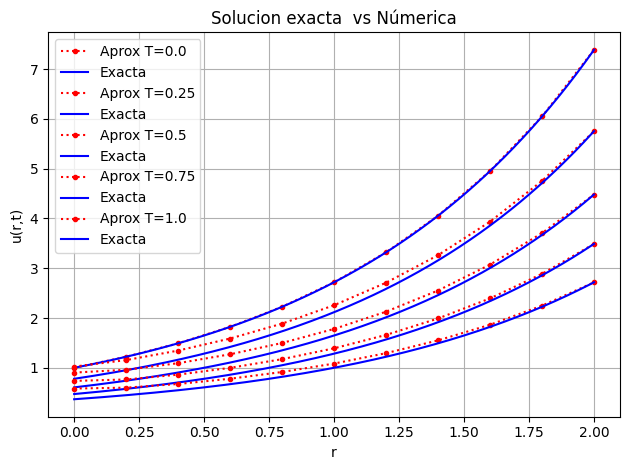

In [9]:
# parámetros problema
problema = 1
manufacturada = True    # para probar las  condiciones de frontera  sin la manufacturada  usar False
t0=0.0
tfin=1.0
x_izq = 0.0
x_der = 2.0

# asumimos un coeficiente de difusión constante
coef_a = 2.0
coef_c = 3.0


#Distintos problemas  de  valor inicial
# Se puede  probar las condiciones de frontera incluso  con la manufacturada

cond_sis = 'esfera'    #  los valores son 'anillo'  o 'lago' o 'esfera'
match cond_sis:
  case 'anillo':
    cond_izq = 'Dirichlet'
    cond_der = 'Dirichlet'
  case 'lago':
    cond_izq = 'Dirichlet'
    cond_der = 'Neumann'
  case 'esfera':
    cond_izq = 'Neumann'
    cond_der = 'Dirichlet'


# parámetros del método en el espacio
M =10
dx = (x_der-x_izq)/M
x_nod = np.linspace(x_izq,x_der,M+1)

# parámetros del método en el tiempo
m=M+1
N = 16
dt=(tfin-t0)/N
th = np.linspace(t0,tfin,N+1)

# configuración tasa de cambio y jacobiano (este último innecesario si el método es explícito)
f = lambda t,U : tasa_cambio_sistema(x_izq,cond_izq,x_der,cond_der,M,t,U,cond_sis)
df= lambda t,U : jacobiano_sistema(x_izq,cond_izq,x_der,cond_der,M,t,U,cond_sis)

# vector de valores iniciales
U0=np.array([u_inicial(x,x_der,cond_sis) for x in x_nod])


# SOLUCIÓN              Habilitar una sola línea

#th,Uh = euler_sistemas(m,t0,U0,f,dt,N)
#th,Uh = backward_euler_sistemas(m,t0,U0,f,df,dt,N)
th,Uh = punto_medio_sistemas(m,t0,U0,f,df,dt,N)
#th,Uh = rk4_sistemas(m,t0,U0,f,dt,N)



# VISUALIZACIÓN

pasos_muestra = [ 0 , int(N//4) , int(N//2) , int(N*3//4) , N ]

plt.figure()
for  n in pasos_muestra:
    graf_solucion_discreta(x_nod,Uh[:,n],text="T="+str(th[n]))
    plt.title("Solucion exacta  vs Númerica")
    if manufacturada:
      graf_solucion_continua(lambda x: u_exacta(x,th[n]) ,x_izq,x_der )
    plt.legend()

# Ajustar el layout
plt.tight_layout()
plt.show()


# Analisis de Error

In [10]:
def errorabs(U_aprox,M,N):
  aux=np.zeros((M+1,N+1))
  aux2=np.zeros((M+1,N+1))
  for  i  in range(M+1):
    for  n in range(N+1):
      aux[i,n]=abs(U_aprox[i,n]-u_exacta(x_nod[i],th[n]))
      aux2[i,n]=abs(u_exacta(x_nod[i],th[n]))

  MaxNum=aux.max()
  MaxDem=aux2.max()

  Error=MaxNum/MaxDem
  return Error

def errorabs_aprox(U_aprox,U_fina,M,N): #  función  cálculo de error  para   solucion aproximada
  aux=np.zeros((M+1,N+1))
  aux2=np.zeros((M+1,N+1))

  for  i  in range(M+1):
    for  n in range(N+1):
      aux[i,n]=abs(U_aprox[i,n]-U_fina[i,n])
      aux2[i,n]=abs(U_fina[i,n])

  MaxNum=aux.max()
  MaxDem=aux2.max()

  Error=MaxNum/MaxDem
  return Error

In [11]:
# parámetros problema
problema = 2
manufacturada = True    # para probar las  condiciones de frontera  sin la manufacturada  usar False
t0=0.0
tfin=1.0
x_izq = 0.0
x_der = 2.0

# asumimos un coeficiente de difusión constante
coef_a = 2.0
coef_c = 3.0

cond_sis = 'anillo'  # cambiar  el nombre  para elegir la  combinacion de condiciones iniciales
match cond_sis:
  case 'anillo':
    cond_izq = 'Dirichlet'
    cond_der = 'Dirichlet'
  case 'lago':
    cond_izq = 'Dirichlet'
    cond_der = 'Neumann'
  case 'esfera':
    cond_izq = 'Neumann'
    cond_der = 'Dirichlet'


## analisis de error con manofacturada

In [ ]:
errorht=np.eye(8)
errorht2=np.eye(8)

M0=32*2
Marray=np.array([.125*M0,0.25*M0,0.5*M0,M0,2*M0,4*M0,8*M0,16*M0], dtype=int)
harray =(x_der-x_izq)/Marray
N0=32*2
Narray=np.array([.125*N0,0.25*N0,0.5*N0,N0,2*N0,4*N0,8*N0,16*N0], dtype=int)
dtarray= (tfin-t0)/Narray


for i,M in enumerate(Marray):
  dx=harray[i]
  x_nod = np.linspace(x_izq,x_der,M+1)

  f = lambda t,U : tasa_cambio_sistema(x_izq,cond_izq,x_der,cond_der,M,t,U,cond_sis)
  df= lambda t,U : jacobiano_sistema(x_izq,cond_izq,x_der,cond_der,M,t,U,cond_sis)
  U0=np.array([u_inicial(x,x_der,cond_sis) for x in x_nod])


  for  n,N in enumerate(Narray):
    dt=dtarray[n]
    th = np.linspace(t0,tfin,N+1)

    th1,Uh1 = backward_euler_sistemas(M+1,t0,U0,f,df,dt,N)
    th2,Uh2 = punto_medio_sistemas(M+1,t0,U0,f,df,dt,N)

    errorht[i][n]=errorabs(Uh1,M,N)
    errorht2[i][n]=errorabs(Uh2,M,N)



Error al calcular solución para el paso  6
Error al calcular solución para el paso  2
Error al calcular solución para el paso  9
Error al calcular solución para el paso  4
Error al calcular solución para el paso  23
Error al calcular solución para el paso  47
Error al calcular solución para el paso  1
Error al calcular solución para el paso  1
Error al calcular solución para el paso  1
Error al calcular solución para el paso  1
Error al calcular solución para el paso  1
Error al calcular solución para el paso  1
Error al calcular solución para el paso  5
Error al calcular solución para el paso  5
Error al calcular solución para el paso  18
Error al calcular solución para el paso  20
Error al calcular solución para el paso  167
Error al calcular solución para el paso  78
Error al calcular solución para el paso  379
Error al calcular solución para el paso  436
Error al calcular solución para el paso  1
Error al calcular solución para el paso  1
Error al calcular solución para el paso  1


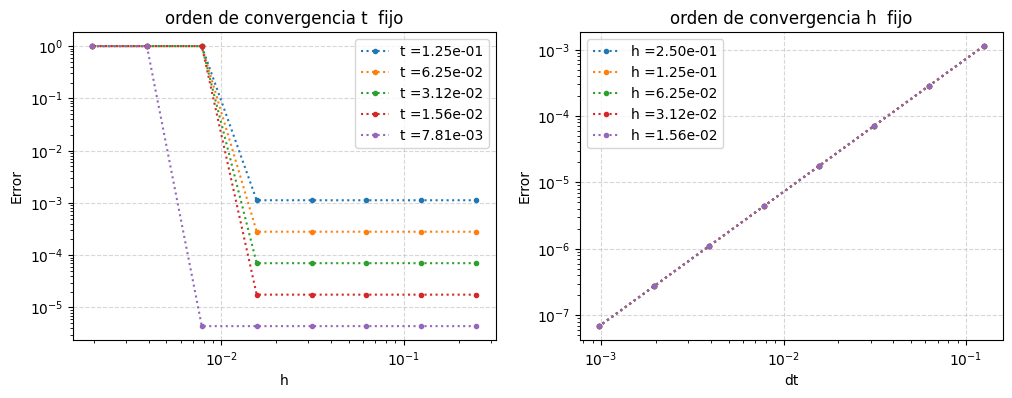

In [ ]:
# Grafica de los errorres  con todas las posibles  combinaciones de pasos   h y  dt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for z in range(5):
  ax1.loglog(harray, errorht2[:,z],':.' , label= 't ={:.2e}'.format(dtarray[z]))  # errorht-> backward  Eueler,  errorht2-> para punto medio

ax1.legend()
ax1.set_title('orden de convergencia t  fijo')
ax1.set_xlabel('h')
ax1.set_ylabel('Error')
ax1.grid(True, linestyle='--', alpha=0.5)

for z in range(5):
  ax2.loglog(dtarray, errorht2[z,:],':.', label= 'h ={:.2e}'.format(harray[z])) # errorht-> backward  Eueler,  errorht2-> para punto medio

ax2.legend()
ax2.set_title('orden de convergencia h  fijo')
ax2.set_xlabel('dt')
ax2.set_ylabel('Error')
ax2.grid(True, linestyle='--', alpha=0.5)

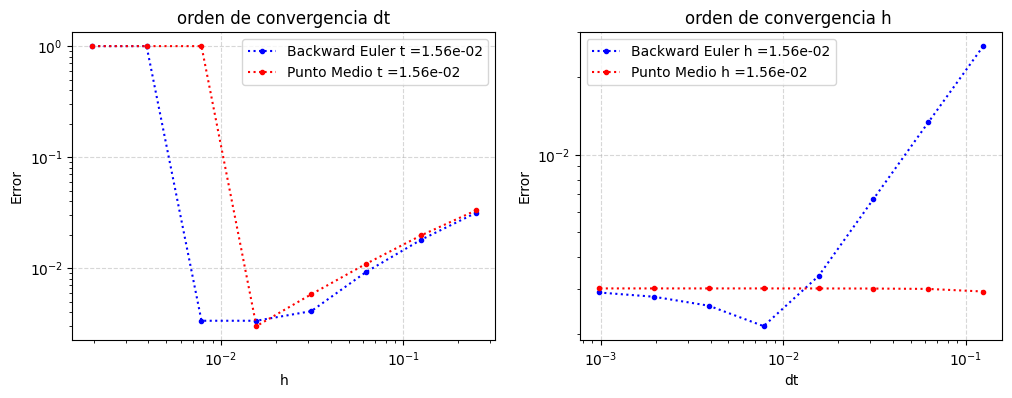

In [ ]:
#Grafica de comparación  entre dos  metodos de  integración en el tiempo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.loglog(harray, errorht[:,3],':.b', label= 'Backward Euler t ={:.2e}'.format(dtarray[3]))
ax1.loglog(harray, errorht2[:,3],':.r', label= 'Punto Medio t ={:.2e}'.format(dtarray[3]))

ax1.legend()
ax1.set_title('orden de convergencia dt')
ax1.set_xlabel('h')
ax1.set_ylabel('Error')
ax1.grid(True, linestyle='--', alpha=0.5)


ax2.loglog(dtarray, errorht[4,:],':.b'  , label= 'Backward Euler h ={:.2e}'.format(harray[4]))
ax2.loglog(dtarray, errorht2[4,:],':.r' , label= 'Punto Medio h ={:.2e}'.format(harray[4]))

ax2.legend()
ax2.set_title('orden de convergencia h ')
ax2.set_xlabel('dt')
ax2.set_ylabel('Error')
ax2.grid(True, linestyle='--', alpha=0.5)

## Corrección del error por  proyección,con numérica

In [13]:
#Solucion con la malla mas fina

# parámetros del método en el espacio
M =32*16
dx = (x_der-x_izq)/M
x_nod_fina = np.linspace(x_izq,x_der,M+1)

# parámetros del método en el tiempo
m=M+1
N = 32*16
dt=(tfin-t0)/N
th = np.linspace(t0,tfin,N+1)

# configuración tasa de cambio y jacobiano (este último innecesario si el método es explícito)
f = lambda t,U : tasa_cambio_sistema(x_izq,cond_izq,x_der,cond_der,M,t,U,cond_sis)
df= lambda t,U : jacobiano_sistema(x_izq,cond_izq,x_der,cond_der,M,t,U,cond_sis)

# vector de valores iniciales
U0=np.array([u_inicial(x,x_der,cond_sis) for x in x_nod_fina])


# SOLUCIÓN              Habilitar una sola línea
th_fina_1,Uh_fina_1 = backward_euler_sistemas(m,t0,U0,f,df,dt,N)
th_fina,Uh_fina = punto_medio_sistemas(m,t0,U0,f,df,dt,N)
#th_fina,Uh_fina =rk4_sistemas(m,t0,U0,f,dt,N)




KeyboardInterrupt: 

In [ ]:
#Solucion aproximada

def solucion_aprox(M,N):
# parámetros del método en el espacio
  dx = (x_der-x_izq)/M
  x_nod = np.linspace(x_izq,x_der,M+1)

# parámetros del método en el tiempo
  m=M+1
  dt=(tfin-t0)/N
  th = np.linspace(t0,tfin,N+1)

# configuración tasa de cambio y jacobiano (este último innecesario si el método es explícito)
  f = lambda t,U : tasa_cambio_sistema(x_izq,cond_izq,x_der,cond_der,M,t,U,cond_sis)
  df= lambda t,U : jacobiano_sistema(x_izq,cond_izq,x_der,cond_der,M,t,U,cond_sis)

# vector de valores iniciales
  U0=np.array([u_inicial(x,x_der,cond_sis) for x in x_nod])


# SOLUCIÓN              Habilitar una sola línea
  th_aprox_1,Uh_aprox_1 = backward_euler_sistemas(m,t0,U0,f,df,dt,N)
  th_aprox,Uh_aprox = punto_medio_sistemas(m,t0,U0,f,df,dt,N)

  return x_nod,th_aprox,Uh_aprox, th_aprox_1,Uh_aprox_1




In [ ]:
# calculo del error con respecto a el paso  temporal
M=32*16
N0=32
Narray=np.array([.125*N0,0.25*N0,0.5*N0,N0,2*N0,4*N0,8*N0,16*N0], dtype=int)
dtarray= (tfin-t0)/Narray

errorht=[]
errorht_1=[]

for N in Narray:
  _,th_aprox,Uh_aprox,th_aprox_1,Uh_aprox_1=solucion_aprox(M,N)

#se proyecta la solución fina sobre el espacio de la aproximada
  Uh_proyectada=np.ones_like(Uh_aprox)
  for n in range(N+1):
    for i in range(513):
      if th_aprox[n]==th_fina[i]:
        Uh_proyectada[:,n]=Uh_fina[:,i]

  e=errorabs_aprox(Uh_aprox,Uh_proyectada,M,N)
  errorht.append(e)


  Uh_proyectada_1=np.ones_like(Uh_aprox_1)
  for n in range(N+1):
    for i in range(513):
      if th_aprox_1[n]==th_fina_1[i]:
        Uh_proyectada_1[:,n]=Uh_fina_1[:,i]

  e=errorabs_aprox(Uh_aprox_1,Uh_proyectada_1,M,N)
  errorht_1.append(e)


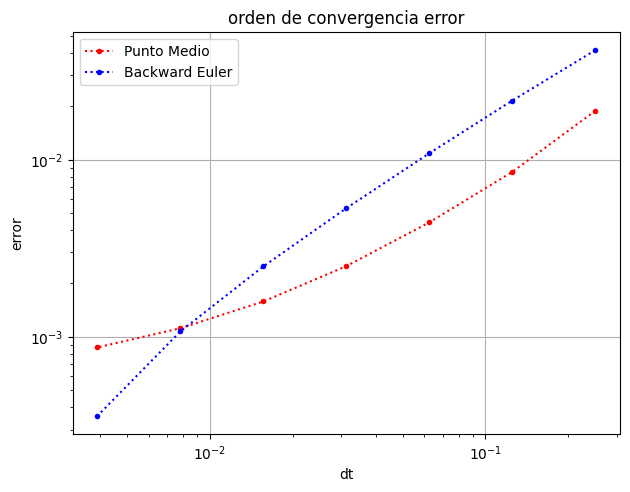

In [ ]:
# Grafica de los errorres   error vs  delta  t
plt.figure()
plt.loglog(dtarray[:-1],errorht[:-1],':.r',label='Punto Medio')
plt.loglog(dtarray[:-1],errorht_1[:-1],':.b',label='Backward Euler')
plt.legend()
plt.xlabel("dt")
plt.ylabel("error")
plt.tight_layout()
plt.title("orden de convergencia error")
plt.grid(True)
plt.show()

In [ ]:
# calculo del error con respecto a el paso espacial
N=32*16
M0=32
Marray=np.array([0.25*M0,0.5*M0,M0,2*M0,4*M0,8*M0,16*M0], dtype=int)
harray =(x_der-x_izq)/Marray

errorht=[]
errorht_1=[]

for M in Marray:
  xh_nod,th_aprox,Uh_aprox,th_aprox_1,Uh_aprox_1=solucion_aprox(M,N)

#se proyecta la solución fina sobre el espacio de la aproximada
  Uh_proyectada=np.ones_like(Uh_aprox)
  for n in range(M+1):
    for i in range(513):
      if xh_nod[n]==x_nod_fina[i]:
        Uh_proyectada[n,:]=Uh_fina[i,:]

  e=errorabs_aprox(Uh_aprox,Uh_proyectada,M,N)
  errorht.append(e)

  #se proyecta la solución fina sobre el espacio de la aproximada
  Uh_proyectada_1=np.ones_like(Uh_aprox)
  for n in range(M+1):
    for i in range(513):
      if xh_nod[n]==x_nod_fina[i]:
        Uh_proyectada_1[n,:]=Uh_fina_1[i,:]

  e=errorabs_aprox(Uh_aprox_1,Uh_proyectada_1,M,N)
  errorht_1.append(e)



/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


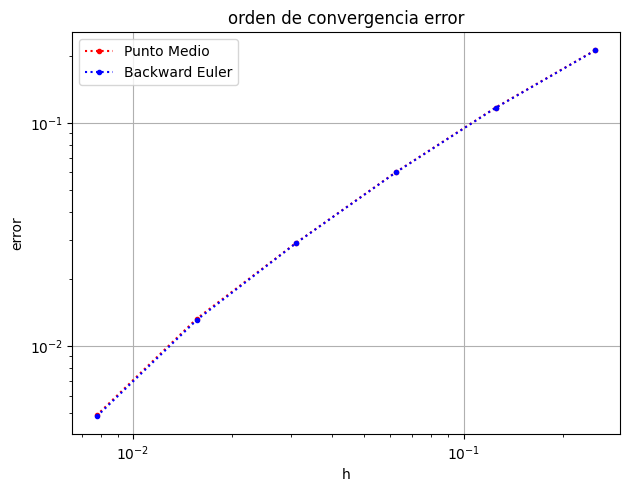

In [ ]:
# Grafica de los errorres   error vs  h
plt.figure()
plt.loglog(harray[:-1],errorht[:-1],':.r',label='Punto Medio')
plt.loglog(harray[:-1],errorht_1[:-1],':.b',label='Backward Euler')
plt.legend()
plt.xlabel("h")
plt.ylabel("error")
plt.tight_layout()
plt.title("orden de convergencia error")
plt.grid(True)
plt.show()

#Pruebas para problemas  de condicion  inicial  especificos

Se proponen 3 problemas  de  condición inicial  con sus  respectivas  fuentes  y  valores para  analizar las soluciones  no manufacturadas.


* Difusión de Calor en un Anillo (Dirichlet-Dirichlet)
  * CI: $ U(r, 0) = U_0(r) = 100 e^{-(r/R)^2} $
  * CF: $U(0, t)=d_{izq} = 100$  
  * CF: $ U(R, t) =d_{der} = 35$
  * Fuente: $f(r,t)=0.1$

* Difusión de un Contaminante en un Lago Circular (Dirichlet-Neuman)
  * CI: $ U(r, 0) = 0 $
  * CF: $U(0, t)=d_{izq} = 10$  
  * CF: $U_r(R, t) = 0$
  * Fuente: $f(r,t)= 3 sin(\frac{4\pi}{10}t)$

* Reacción-Difusión en un Cuerpo Esférico de Material Reactivo (Neuman-Dirichlet)
  * CI: $ U(r, 0) = U_0(r) = - 40 e^{-(r/R)^2} $
  * CF: $U_r(0, t) = 0$  
  * CF: $U(R, t)=d_{der} = -40$
  * Fuente: $f(r,t)=-0.2x$

In [14]:
# parámetros problema
manufacturada = False    # para probar las  condiciones de frontera  sin la manufacturada  usar False

t0=0.0
tfin=1.0
x_izq = 0.0
x_der = 2.0

# asumimos un coeficiente de difusión  y racción constante
coef_a = 2.0
coef_c = 3.0

cond_sis = 'esfera'   # Para  cambiar  la  configuracion de CF
match cond_sis:
  case 'anillo':
    cond_izq = 'Dirichlet'
    cond_der = 'Dirichlet'
  case 'lago':
    cond_izq = 'Dirichlet'
    cond_der = 'Neumann'
  case 'esfera':
    cond_izq = 'Neumann'
    cond_der = 'Dirichlet'

## solución en dos configuraciones diferentes

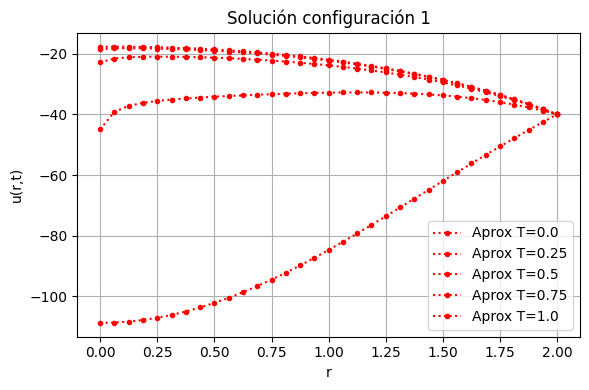

In [15]:
#Configuración 1 -"peor"

# parámetros del método en el espacio
M=32
dx =(x_der-x_izq)/M
x_nod = np.linspace(x_izq,x_der,M+1)

# parámetros del método en el tiempo
N=32
dt= (tfin-t0)/N
th= np.linspace(t0,tfin,N+1)

# configuración tasa de cambio y jacobiano (este último innecesario si el método es explícito)
f = lambda t,U : tasa_cambio_sistema(x_izq,cond_izq,x_der,cond_der,M,t,U,cond_sis)
df= lambda t,U : jacobiano_sistema(x_izq,cond_izq,x_der,cond_der,M,t,U,cond_sis)

# vector de valores iniciales
U0=np.array([u_inicial(x,x_der,cond_sis) for x in x_nod])


# SOLUCIÓN

th_conf1,Uh_conf1 = backward_euler_sistemas(M+1,t0,U0,f,df,dt,N)

# VISUALIZACIÓN
pasos_muestra = [ 0 , int(N//4) , int(N//2) , int(N*3//4) , N ]

plt.figure(figsize=(6, 4))
for  n in pasos_muestra:
    graf_solucion_discreta(x_nod,Uh_conf1[:,n],text="T="+str(th[n]))
    plt.title("Solución configuración 1")
    plt.legend()

plt.tight_layout()
plt.show()

x_nod_conf1=x_nod

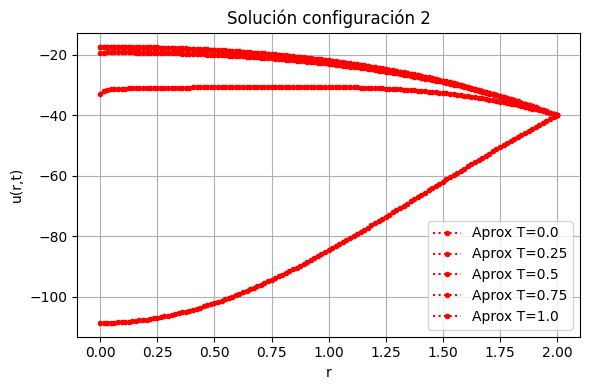

In [16]:
#Configuración 2- "Mejor"

# parámetros del método en el espacio
M=32*4
dx =(x_der-x_izq)/M
x_nod = np.linspace(x_izq,x_der,M+1)

# parámetros del método en el tiempo
N=32*16
dt= (tfin-t0)/N
th = np.linspace(t0,tfin,N+1)

# configuración tasa de cambio y jacobiano (este último innecesario si el método es explícito)
f = lambda t,U : tasa_cambio_sistema(x_izq,cond_izq,x_der,cond_der,M,t,U,cond_sis)
df= lambda t,U : jacobiano_sistema(x_izq,cond_izq,x_der,cond_der,M,t,U,cond_sis)

# vector de valores iniciales
U0=np.array([u_inicial(x,x_der,cond_sis) for x in x_nod])


# SOLUCIÓN
th_conf2,Uh_conf2 = punto_medio_sistemas(M+1,t0,U0,f,df,dt,N)


 # VISUALIZACIÓN
pasos_muestra = [ 0 , int(N//4) , int(N//2) , int(N*3//4) , N ]

plt.figure(figsize=(6, 4))
for  n in pasos_muestra:
    graf_solucion_discreta(x_nod,Uh_conf2[:,n],text="T="+str(th[n]))
    plt.title("Solución configuración 2")
    plt.legend()

plt.tight_layout()
plt.show()

x_nod_conf2=x_nod

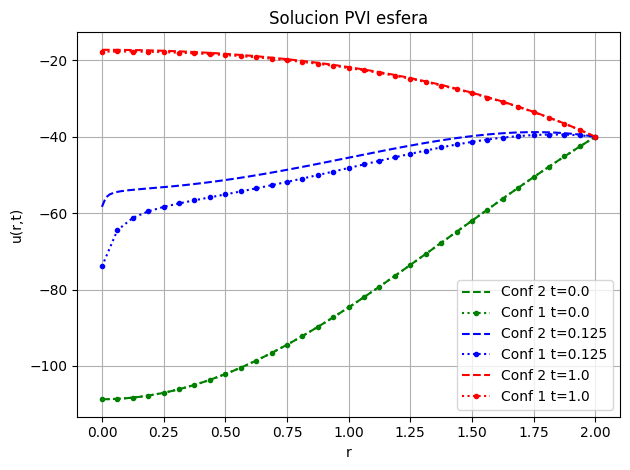

In [17]:
#Grafica  para comparar las  soluciones en las  distintas  configuraciones
plt.figure()
#inicial
plt.plot(x_nod_conf2,Uh_conf2[:,0],'--g',label=('Conf 2 t={}'.format(th_conf2[0])))
plt.plot(x_nod_conf1,Uh_conf1[:,0],':.g',label=('Conf 1 t={}'.format(th_conf1[0])))

#tiempo intermedio
plt.plot(x_nod_conf2,Uh_conf2[:,4*16],'--b',label=('Conf 2 t={}'.format(th_conf2[4*16])))
plt.plot(x_nod_conf1,Uh_conf1[:,4],':.b',label=('Conf 1 t={}'.format(th_conf1[4])))

#final
plt.plot(x_nod_conf2,Uh_conf2[:,-1],'--r',label=('Conf 2 t={}'.format(th_conf2[-1])))
plt.plot(x_nod_conf1,Uh_conf1[:,-1],':.r',label=('Conf 1 t={}'.format(th_conf2[-1])))

plt.xlabel('r')
plt.ylabel('u(r,t)')
plt.title("Solucion PVI {}".format(cond_sis))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# animación de los mejores resultados

para animar cada caso, es necesario ir a la sección anterior y  escojer el PVI  que se desea animar.('anillo','lago', 'esfera') y volver a correr  las  celdas siguientes

Todos los casos  se graficaran en polares y cartesianas

<ipython-input-19-5d6f7215f39d>:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(122, projection='polar')


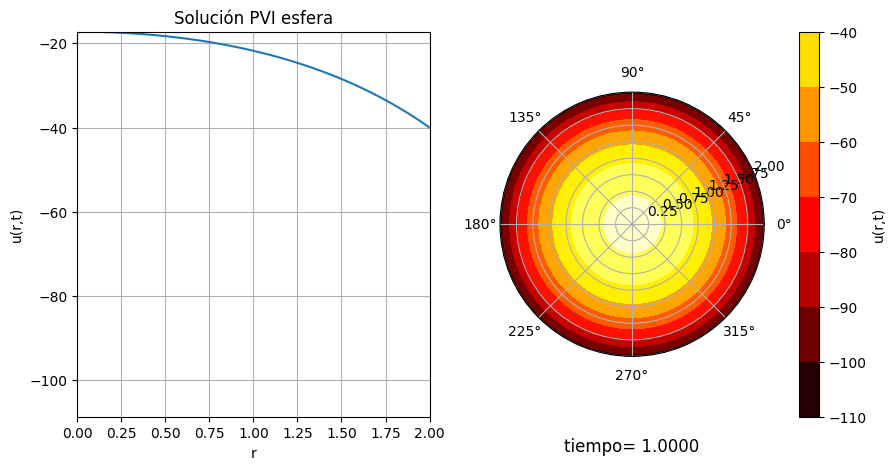

In [19]:
r = x_nod_conf2
u = Uh_conf2
t = th_conf2
nframes =int(len(u[0, :]))

# Crear una malla de ángulos theta y distancias radiales r
theta = np.linspace(0, 2 * np.pi, 100)
r_grid, theta_grid = np.meshgrid(r, theta)

# Inicialización de la figura en coordenadas polares
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={})


#sub plot1 polar
ax1 = plt.subplot(122, projection='polar')
cont = ax1.contourf(theta_grid, r_grid, np.tile(u[:, 0], (100, 1)), cmap='hot')
cont.set_clim(np.min(u), np.max(u))
cbar = fig.colorbar(cont, ax=ax1, orientation='vertical', pad=0.1)

cbar.set_label('u(r,t)')
ax1.grid(True)

# sub plot2  cartesiano
ax2 = plt.subplot(121)
line2, = ax2.plot(r, u[:,0])
ax2.set_xlim(0, 2)
ax2.set_ylim(np.min((u)), np.max((u)))
#ax2.set_ylim(0, 110)
ax2.set_xlabel('r')
ax2.set_ylabel('u(r,t)')
ax2.grid(True)


# Función para inicializar la animación
def init():
    ax1.set_ylim(0, 2.1)
    cont = ax1.contourf(theta_grid, r_grid, np.tile(u[:, 0], (100, 1)), cmap='hot')
    cont.set_clim(np.min(u), np.max(u))

    line2.set_ydata(u[:,0])
    return cont.collections + [line2]

# Función para actualizar la animación
def animate(i):
    ax1.clear()
    #cbar.remove()
    ax1.set_ylim(0, np.max(r))
    cont = ax1.contourf(theta_grid, r_grid, np.tile(u[:, i], (100, 1)), cmap='hot')



    ax1.text(3*np.pi/2, 3.5, 'tiempo= {:.4f}'.format(t[i]), fontsize=12, ha='center', va='bottom')

    line2.set_ydata(u[:,i])
    plt.title("Solución PVI {}".format(cond_sis))
    return cont.collections + [line2]

# Crear la animación
animation = FuncAnimation(fig, animate, init_func=init, frames=nframes, interval=50)
animation.save('animation_polar_heatmap.gif', writer='imagemagick')


plt.show()
